In [27]:
from IPython.display import Image

### norm

> 稳定加速训练；
- batch norm, layer norm

In [28]:
Image(url='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*vXpodxSx-nslMSpOELhovg.png', width=400)

### 避免局部最优

- sgd
    - 使用单个或小批量样本计算出的梯度是对整体梯度的一个有噪声的估计。这个“噪声”正是关键！它可能偶尔会指向一个“错误”的方向，但这个错误的方向恰好可能帮助参数“越过”某个局部最优点的“山丘”
- 动量法 (Momentum）
    - 它像一个从山上滚下来的铁球。当它冲到局部最优的坑底时，由于积累的惯性（动量），它没有停下，而是直接“冲”上了对面的山坡，成功越过了障碍。
- Adam 要用更大的学习率；
    - 否则下降得非常慢；
- 如下代码
    - 对学习率比较敏感；

gd: 3.837987184524536
sgd: 3.8703629970550537
momentum: -1.296283483505249
adam: -1.5369657278060913
sa: 3.524017066203674
lbfgs: -1.306439995765686


(-10.0, 80.0)

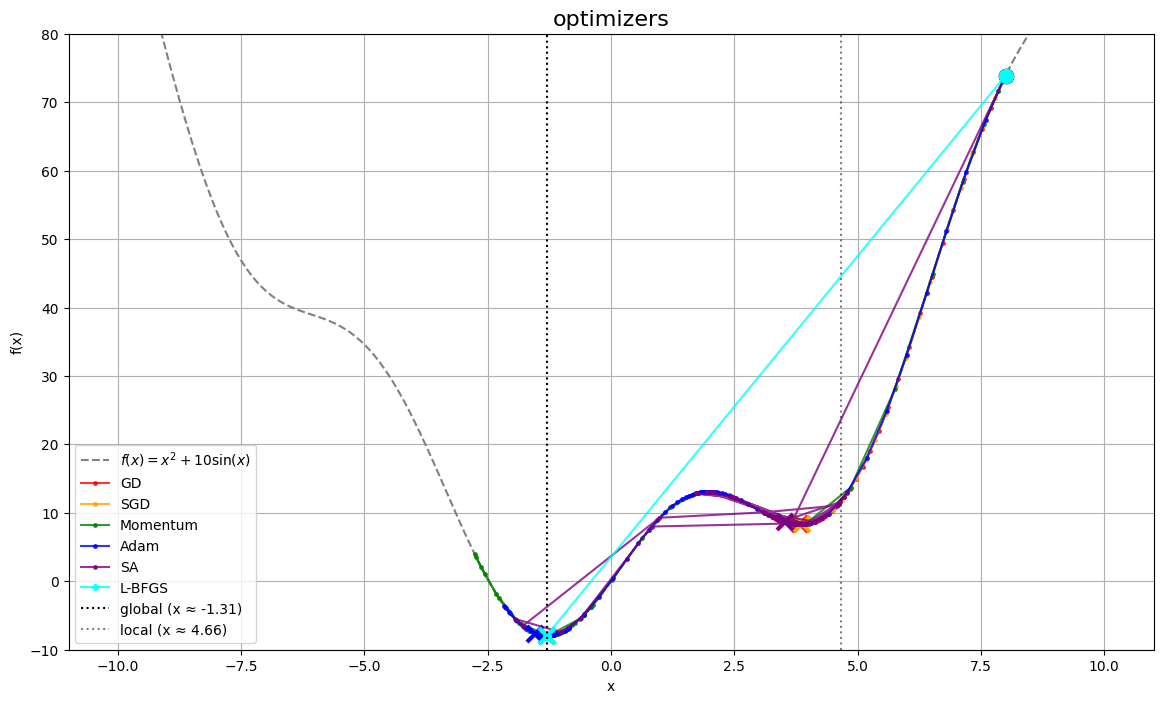

In [23]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math


# 1. 定义我们的“陷阱”函数
def loss_function(x):
    return x**2 + 10 * torch.sin(x)

# 2. 优化器运行函数
def run_optimizer(optimizer_name, x_start, lr, momentum=0, epochs=60):
    x = torch.tensor([x_start], dtype=torch.float32, requires_grad=True)
    
    if optimizer_name == 'GD':
        # 标准梯度下降（用SGD模拟，batch size为1，无动量）
        optimizer = optim.SGD([x], lr=lr)
    elif optimizer_name == 'SGD_Noise':
        # 模拟带噪声的SGD（手动添加噪声）
        # 在真实场景中，噪声来自mini-batch的随机性
        optimizer = optim.SGD([x], lr=lr)
    elif optimizer_name == 'Momentum':
        optimizer = optim.SGD([x], lr=lr, momentum=momentum)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam([x], lr=lr)
    else:
        raise ValueError("Unknown optimizer")

    path = []
    for i in range(epochs):
        path.append(x.item())
        optimizer.zero_grad()
        loss = loss_function(x)
        loss.backward()
        
        if optimizer_name == 'SGD_Noise':
            # 手动为梯度增加噪声，模拟真实SGD的效果
            noise = torch.randn(1) * 5.0 # 噪声强度可以调整
            x.grad += noise

        optimizer.step()
        
    return path

# 3. L-BFGS 优化器运行函数 (注意其结构不同)
def run_lbfgs(x_start, epochs=15): # L-BFGS 通常收敛很快，不需要很多epoch
    x = torch.tensor([x_start], dtype=torch.float32, requires_grad=True)
    # L-BFGS 的学习率通常设为1，因为它内部会计算步长
    optimizer = optim.LBFGS([x], lr=1, max_iter=20)
    
    path = [x.item()]

    for i in range(epochs):
        # 定义 closure 函数
        def closure():
            optimizer.zero_grad()
            loss = loss_function(x)
            loss.backward()
            return loss
        
        optimizer.step(closure)
        path.append(x.item())
        
    return path

# 3. 模拟退火 (Simulated Annealing) 的实现
def run_simulated_annealing(x_start, epochs=60, initial_temp=20.0, final_temp=0.1, alpha=0.95):
    current_x = x_start
    current_loss = loss_function(torch.tensor([current_x])).item()
    
    T = initial_temp
    path = [current_x]

    for i in range(epochs):
        # 在当前解的邻域内随机找一个新解
        # 步长随着温度下降而减小
        step_size = T / initial_temp 
        new_x = current_x + np.random.uniform(-1, 1) * step_size * 5

        new_loss = loss_function(torch.tensor([new_x])).item()
        
        delta_e = new_loss - current_loss
        
        # 如果是更好的解，或者根据Metropolis准则接受差解
        if delta_e < 0 or math.exp(-delta_e / T) > np.random.rand():
            current_x = new_x
            current_loss = new_loss
        
        path.append(current_x)
        
        # 降温
        T *= alpha
        if T < final_temp:
            break
            
    return path


# --- 主程序 ---
# 参数设置
start_x = 8.0
learning_rate = 0.01
momentum_val = 0.9
num_epochs = 100

# 运行所有优化器
path_gd = run_optimizer('GD', start_x, lr=learning_rate, epochs=num_epochs)
path_sgd_noise = run_optimizer('SGD_Noise', start_x, lr=learning_rate, epochs=num_epochs)
path_momentum = run_optimizer('Momentum', start_x, lr=learning_rate, momentum=momentum_val, epochs=num_epochs)
path_adam = run_optimizer('Adam', start_x, lr=0.4, epochs=num_epochs) # Adam通常用稍大的学习率
path_sa = run_simulated_annealing(start_x, epochs=num_epochs)
path_lbfgs = run_lbfgs(start_x, epochs=num_epochs)


print(f'gd: {path_gd[-1]}')
print(f'sgd: {path_sgd_noise[-1]}')
print(f'momentum: {path_momentum[-1]}')
print(f'adam: {path_adam[-1]}')
print(f'sa: {path_sa[-1]}')
print(f'lbfgs: {path_lbfgs[-1]}')


# --- 可视化 ---
x_vals = np.linspace(-10, 10, 400)
y_vals = loss_function(torch.tensor(x_vals)).numpy()

plt.figure(figsize=(14, 8))
plt.plot(x_vals, y_vals, label='$f(x) = x^2 + 10 \sin(x)$', color='gray', linestyle='--')

# 绘制每个优化器的路径
def plot_path(path, label, color, marker):
    y_path = loss_function(torch.tensor(path)).numpy()
    plt.plot(path, y_path, label=label, color=color, marker=marker, markersize=5, alpha=0.8)
    plt.plot(path[0], y_path[0], marker='o', markersize=10, color=color) # 起点
    plt.plot(path[-1], y_path[-1], marker='x', markersize=12, markeredgewidth=3, color=color) # 终点

plot_path(path_gd, 'GD', 'red', '.')
plot_path(path_sgd_noise, 'SGD', 'orange', '.')
plot_path(path_momentum, 'Momentum', 'green', '.')
plot_path(path_adam, 'Adam', 'blue', '.')
plot_path(path_sa, 'SA', 'purple', '.')
plot_path(path_lbfgs, 'L-BFGS', 'cyan', 'P') # 用不同标记


# 标记最优点
global_min_x = -1.3064
local_min_x = 4.6583
plt.axvline(global_min_x, color='black', linestyle=':', label=f'global (x ≈ {global_min_x:.2f})')
plt.axvline(local_min_x, color='black', linestyle=':', alpha=0.5, label=f'local (x ≈ {local_min_x:.2f})')


plt.title('optimizers', fontsize=16)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.ylim(-10, 80)

In [26]:
# path_lbfgs